<a href="https://colab.research.google.com/github/albert-yue/gcn-explainability/blob/master/notebooks/experiment_r52.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd gdrive/My\ Drive/MIT/gcn_explainability/

/content/gdrive/My Drive/MIT/gcn_explainability


In [0]:
!git pull

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/albert-yue/gcn-explanability
   f954ed8..7535d84  master     -> origin/master
Updating f954ed8..7535d84
Fast-forward
 notebooks/experiment_sst.ipynb | 3306 ++++++++++++++++++++++++++++++++++++++++
 1 file changed, 3306 insertions(+)
 create mode 100644 notebooks/experiment_sst.ipynb


# Set up Vocabulary and Labels

In [0]:
from src.data import save_all_labels

save_all_labels('data/r52-labels.txt', 'data/train-r52.txt', 'data/test-r52.txt')

In [0]:
from tqdm.auto import tqdm

def save_vocabulary(out_path, train_path, test_path, doc_freq_threshold=5):
    word_freqs = {}  # counting num of docs
    for data_path in [train_path, test_path]:
        with open(data_path, 'r') as f:
            for line in tqdm(f.readlines()):
                line = line.strip()
                _, text = line.split('\t')
                words = text.split()
                for w in set(words):
                    w = w.strip()
                    if w in word_freqs:
                        word_freqs[w] += 1
                    else:
                        word_freqs[w] = 1
    vocab = []
    for w, freq in word_freqs.items():
        if freq >= doc_freq_threshold:
            vocab.append(w)
    with open(out_path, 'w+') as f:
        f.write('\n'.join(vocab))

In [0]:
save_vocabulary('data/r52-vocabulary.txt', 'data/train-r52.txt', 'data/test-r52.txt')

# Training

In [0]:
from src.data import Corpus, get_data, get_vocabulary, get_labels
from src.models.gcn import GCN
from src.preprocessing import clean_text, build_adj_matrix, normalize_adj
from src.train import train, evaluate, accuracy

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from matplotlib import pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.title("R52 Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend(loc='lower left')

In [0]:
seed = 0
val_split = 0.1

vocab = get_vocabulary('data/r52-vocabulary.txt')
labels = get_labels('data/r52-labels.txt')
corpus = get_data('data/train-r52.txt', labels)
test_corpus = get_data('data/test-r52.txt', labels)

# Split validation set
corpus.shuffle(seed)
len_train = int(len(corpus) * (1 - val_split))
train_corpus = Corpus(corpus[:len_train])
val_corpus = Corpus(corpus[len_train:])

num_documents = len(train_corpus) + len(val_corpus) + len(test_corpus)

In [0]:
# Mask out unknown words
clean_text(corpus, vocab)
clean_text(test_corpus, vocab)

In [0]:
train_adj_matrix = build_adj_matrix(train_corpus, vocab, num_documents, doc_offset=0)
val_adj_matrix = build_adj_matrix(val_corpus, vocab, num_documents, doc_offset=len(train_corpus))
test_adj_matrix = build_adj_matrix(test_corpus, vocab, num_documents, doc_offset=len(train_corpus) + len(val_corpus))

Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities



Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities



Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities


In [0]:
from src.utils import save_sparse_tensor

save_sparse_tensor(train_adj_matrix, 'data/r52_train_adj_matrix.pt')
save_sparse_tensor(val_adj_matrix, 'data/r52_val_adj_matrix.pt')
save_sparse_tensor(test_adj_matrix, 'data/r52_test_adj_matrix.pt')

In [0]:
from src.utils import load_sparse_tensor

train_adj_matrix = load_sparse_tensor('data/r52_train_adj_matrix.pt')
val_adj_matrix = load_sparse_tensor('data/r52_val_adj_matrix.pt')
test_adj_matrix = load_sparse_tensor('data/r52_test_adj_matrix.pt')

In [0]:
train_adj_matrix = normalize_adj(train_adj_matrix)
val_adj_matrix = normalize_adj(val_adj_matrix)
test_adj_matrix = normalize_adj(test_adj_matrix)

In [0]:
hidden_size = 200  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 700
lr = 0.02

num_vertices = len(vocab) + num_documents
model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)

In [0]:
%time train_losses, val_losses = train(model, train_adj_matrix, val_adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='r52_train.pt')

Epoch 0
Train mean cross-entropy: 3.9511983394622803
Validation mean cross-entropy: 3.883282423019409
Epoch 10
Train mean cross-entropy: 2.222351312637329
Validation mean cross-entropy: 2.7319843769073486
Epoch 20
Train mean cross-entropy: 1.5813546180725098
Validation mean cross-entropy: 2.29337739944458
Epoch 30
Train mean cross-entropy: 1.2049384117126465
Validation mean cross-entropy: 1.9220281839370728
Epoch 40
Train mean cross-entropy: 0.9469305872917175
Validation mean cross-entropy: 1.8204712867736816
Epoch 50
Train mean cross-entropy: 0.7099745869636536
Validation mean cross-entropy: 1.6470983028411865
Epoch 60
Train mean cross-entropy: 0.5300287008285522
Validation mean cross-entropy: 1.6049593687057495
Epoch 70
Train mean cross-entropy: 0.3941210210323334
Validation mean cross-entropy: 1.5657336711883545
Epoch 80
Train mean cross-entropy: 0.29735371470451355
Validation mean cross-entropy: 1.621703863143921
CPU times: user 1min 39s, sys: 703 ms, total: 1min 40s
Wall time: 1mi

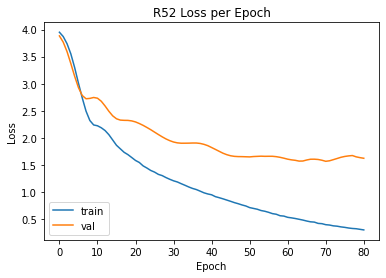

In [0]:
plot_loss(train_losses, val_losses)

In [0]:
test_start_idx = len(vocab) + len(train_corpus) + len(val_corpus)
test_loss = evaluate(model, test_adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
print(test_loss)

0.544392523364486


## Full Matrix

In [0]:
full_corpus = Corpus(train_corpus.data + val_corpus.data + test_corpus.data)

In [0]:
%time adj_matrix = build_adj_matrix(full_corpus, vocab, num_documents, doc_offset=0)

Building word frequencies per doc



Building word frequencies per window



Calculating PMIs



Calculating TF-IDF



Identities



CPU times: user 1min 5s, sys: 888 ms, total: 1min 6s
Wall time: 1min 6s


In [0]:
from src.utils import save_sparse_tensor

save_sparse_tensor(adj_matrix, 'data/r52_full_adj_matrix.pt')

In [0]:
from src.utils import load_sparse_tensor

adj_matrix = load_sparse_tensor('data/r52_full_adj_matrix.pt')

In [0]:
adj_matrix = normalize_adj(adj_matrix)

In [0]:
hidden_size = 200  # hyperparameter
dropout = 0.5  # hyperparameter
epochs = 700
lr = 0.02

num_vertices = len(vocab) + num_documents
model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)

In [0]:
%time train_losses, val_losses = train(model, adj_matrix, adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='gcn_r52_full.pt')

Epoch 0
Train mean cross-entropy: 3.951373815536499
Validation mean cross-entropy: 3.881131410598755
Epoch 10
Train mean cross-entropy: 2.212151050567627
Validation mean cross-entropy: 2.0722410678863525
Epoch 20
Train mean cross-entropy: 1.576442003250122
Validation mean cross-entropy: 1.4344053268432617
Epoch 30
Train mean cross-entropy: 1.1724390983581543
Validation mean cross-entropy: 1.1035727262496948
Epoch 40
Train mean cross-entropy: 0.9091047644615173
Validation mean cross-entropy: 0.8632068634033203
Epoch 50
Train mean cross-entropy: 0.6932972073554993
Validation mean cross-entropy: 0.6684395670890808
Epoch 60
Train mean cross-entropy: 0.5231521725654602
Validation mean cross-entropy: 0.5186992287635803
Epoch 70
Train mean cross-entropy: 0.3970162272453308
Validation mean cross-entropy: 0.4068912863731384
Epoch 80
Train mean cross-entropy: 0.30679863691329956
Validation mean cross-entropy: 0.3303185701370239
Epoch 90
Train mean cross-entropy: 0.24055077135562897
Validation me

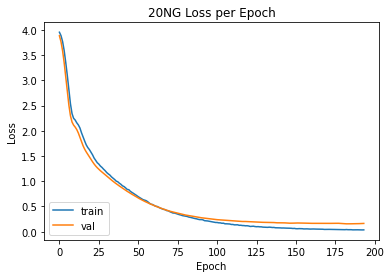

In [0]:
plot_loss(train_losses, val_losses)

In [0]:
test_start_idx = len(vocab) + len(train_corpus) + len(val_corpus)
test_acc = evaluate(model, adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
print(test_acc)

0.9439252336448598


In [0]:
print(train_losses)
print(val_losses)

[3.951373815536499, 3.884178400039673, 3.7683005332946777, 3.5912363529205322, 3.3558731079101562, 3.0962016582489014, 2.8174259662628174, 2.5323970317840576, 2.3396689891815186, 2.2465574741363525, 2.212151050567627, 2.157785415649414, 2.1157119274139404, 2.055211067199707, 1.9602340459823608, 1.8774975538253784, 1.797263741493225, 1.7209680080413818, 1.6670551300048828, 1.627304196357727, 1.576442003250122, 1.5236539840698242, 1.4594906568527222, 1.41326105594635, 1.3671103715896606, 1.3389736413955688, 1.3002002239227295, 1.2732856273651123, 1.2388705015182495, 1.2087734937667847, 1.1724390983581543, 1.1453537940979004, 1.1223008632659912, 1.0868607759475708, 1.0616710186004639, 1.0347404479980469, 1.0026377439498901, 0.9894213080406189, 0.9612031579017639, 0.939252495765686, 0.9091047644615173, 0.8942274451255798, 0.8679487705230713, 0.837487518787384, 0.8326296210289001, 0.7992767095565796, 0.7800160646438599, 0.7584511637687683, 0.7379064559936523, 0.7167414426803589, 0.693297207

In [0]:
import numpy as np

repeats = 10
repeats_test_acc = []
for i in range(repeats):
    model = GCN(num_vertices, hidden_size, len(labels), dropout=dropout)
    train(model, adj_matrix, adj_matrix, train_corpus.labels(), val_corpus.labels(), len(vocab), epochs=epochs, init_lr=lr, plot_every=5, print_every=10, save_path='gcn_r52_full_repeats.pt')
    test_acc = evaluate(model, adj_matrix, test_corpus.labels(), accuracy, start_idx=test_start_idx)
    repeats_test_acc.append(test_acc)

repeats_test_acc = np.array(repeats_test_acc)
print('Mean %s and std %s' % (np.mean(repeats_test_acc), np.std(repeats_test_acc)))

Epoch 0
Train mean cross-entropy: 3.951357364654541
Validation mean cross-entropy: 3.8779284954071045
Epoch 10
Train mean cross-entropy: 2.2154157161712646
Validation mean cross-entropy: 2.09224009513855
Epoch 20
Train mean cross-entropy: 1.5889772176742554
Validation mean cross-entropy: 1.440697431564331
Epoch 30
Train mean cross-entropy: 1.1736223697662354
Validation mean cross-entropy: 1.0948524475097656
Epoch 40
Train mean cross-entropy: 0.9129543304443359
Validation mean cross-entropy: 0.853573739528656
Epoch 50
Train mean cross-entropy: 0.6990581154823303
Validation mean cross-entropy: 0.6636768579483032
Epoch 60
Train mean cross-entropy: 0.5329960584640503
Validation mean cross-entropy: 0.520187258720398
Epoch 70
Train mean cross-entropy: 0.4055345952510834
Validation mean cross-entropy: 0.4072430729866028
Epoch 80
Train mean cross-entropy: 0.3066556453704834
Validation mean cross-entropy: 0.3297690153121948
Epoch 90
Train mean cross-entropy: 0.23404641449451447
Validation mean 